In [255]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [256]:
import locale
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

# ETL - EDA de Victimas

Este documento contiene el proceso de extraccion, limpieza y transformación de los datos de la tabla **VICTIMAS** al igual que el analisis exploratorio de datos. Esta tabla contiene la imformacion correspondiente a las victimas mortales de siniestros viales que ocurrieron en la Ciudad Autonoma de Buenos Aires entre el año 2016 y 2021.

In [257]:
df_victimas = pd.read_excel('Archivos Origen/homicidios.xlsx', sheet_name='VICTIMAS')
df_victimas

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
712,2021-0092,2021-12-12,2021,12,12,PEATON,PEATON,FEMENINO,50,2021-12-12 00:00:00
713,2021-0093,2021-12-13,2021,12,13,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,18,2021-12-18 00:00:00
714,2021-0094,2021-12-20,2021,12,20,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,43,2021-12-20 00:00:00
715,2021-0095,2021-12-30,2021,12,30,CONDUCTOR,MOTO,MASCULINO,27,2022-01-02 00:00:00


In [258]:
df_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


## Manejo de duplicados

Se realizó la revisión de duplicados del dataset y se encontró que no existian valores repetidos para todas las columnas

In [259]:
df_victimas[df_victimas.duplicated()]

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO


## Manejos de nulos

Se hizo la revision y se descubrio que no existen valores vacios para este dataset. Sin embargo, conociendo que se tienen el valor *SD* (Sin Dato) se decidió revisar los registros con este valor. Se encontraron 59 registros con este valor y 2 con este valor en todas sus columnas (con excepcion de los datos de fecha del hecho y el id del hecho) por lo cual se decicio borrar esos 2.

In [260]:
df_victimas.isnull().sum()

ID_hecho               0
FECHA                  0
AAAA                   0
MM                     0
DD                     0
ROL                    0
VICTIMA                0
SEXO                   0
EDAD                   0
FECHA_FALLECIMIENTO    0
dtype: int64

In [261]:
df_victimas[(df_victimas['ROL']=='SD')|(df_victimas['VICTIMA']=='SD')|(df_victimas['SEXO']=='SD')|(df_victimas['EDAD']=='SD')].shape[0]

59

In [262]:
df_victimas[(df_victimas['ROL']=='SD')&(df_victimas['VICTIMA']=='SD')&(df_victimas['SEXO']=='SD')&(df_victimas['EDAD']=='SD')]

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
36,2016-0049,2016-04-17,2016,4,17,SD,SD,SD,SD,SD
141,2016-0174,2016-12-27,2016,12,27,SD,SD,SD,SD,SD


In [263]:
df_victimas.drop(df_victimas[(df_victimas['ROL']=='SD')&(df_victimas['VICTIMA']=='SD')&(df_victimas['SEXO']=='SD')&(df_victimas['EDAD']=='SD')].index, inplace=True)

## Transformacion de columnas

### Dia de la semana y Mes

Se decidió extraer el dia de la semana (en numero y nombre) al igual que el nombre del mes, para realizar el analisis y posteriormente para simplificar la visualizacion

In [264]:
df_victimas['DIA_SEMANA_NOM'] = df_victimas['FECHA'].dt.strftime('%A').str.upper()
df_victimas['DIA_SEMANA'] = df_victimas['FECHA'].dt.weekday

In [265]:
df_victimas['MES_NOM'] = df_victimas['FECHA'].dt.month_name(locale='Spanish_Spain.1252').str.upper()

In [266]:
df_victimas.rename(columns={'AAAA':'AÑO', 'MM':'MES', 'DD':'DIA'},inplace=True)

### Edad

Se encontro que existian 51 registros con valor *'SD'* (Sin Dato). Con el fin de realizar un mejor analisis se decidió imputar estos valores. Teniendo en cuenta que tenemos valores enteros repetitivos con una distribucion un poco segada a la derecha, se considero que la mejor opcion era llenar estos valores con la moda (30 años)

In [267]:
df_victimas['EDAD'].describe()

count     715
unique     86
top        SD
freq       51
Name: EDAD, dtype: object

In [268]:
df_victimas[~(df_victimas['EDAD']=='SD')]['EDAD'].value_counts()

EDAD
30    28
29    24
23    24
27    20
28    20
      ..
11     1
92     1
12     1
5      1
88     1
Name: count, Length: 85, dtype: int64

In [269]:
df_victimas[~(df_victimas['EDAD']=='SD')]['EDAD'].mode().iloc[0]

30

Text(0.5, 0, 'Edad')

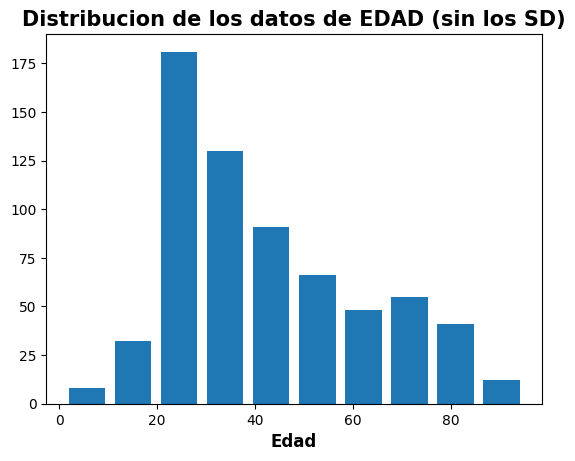

In [270]:
plt.hist(df_victimas[~(df_victimas['EDAD']=='SD')]['EDAD'], rwidth=0.8)
plt.title('Distribucion de los datos de EDAD (sin los SD)',fontweight='bold', fontsize=15)
plt.xlabel('Edad',fontweight = 'bold',fontsize=12)

In [271]:
df_victimas['EDAD'] = df_victimas['EDAD'].apply(lambda x : df_victimas[~(df_victimas['EDAD']=='SD')]['EDAD'].mode().iloc[0] if x == 'SD' else x)

In [272]:
df_victimas['EDAD'] = df_victimas['EDAD'].astype(int)

## Tipo de dato

Al finalizar la limpieza y normalización del DataFrame se tienen 3 tipos de datos para este dataset: 
- **Object (string):** *'ID'*, *'ROL'*, *'VICTIMA'*, *'SEXO'*, *'FECHA_FALLECIMIENTO'*, *'DIA_SEMANA_NOM'*, *'MES_NOM'*
- **Int:** *'AÑO'*, *'MES'*, *'DIA'*, *'EDAD'*, *'DIA_SEMANA'*
- **DateTime:** *'FECHA'*

In [273]:
df_victimas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 0 to 716
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             715 non-null    object        
 1   FECHA                715 non-null    datetime64[ns]
 2   AÑO                  715 non-null    int64         
 3   MES                  715 non-null    int64         
 4   DIA                  715 non-null    int64         
 5   ROL                  715 non-null    object        
 6   VICTIMA              715 non-null    object        
 7   SEXO                 715 non-null    object        
 8   EDAD                 715 non-null    int64         
 9   FECHA_FALLECIMIENTO  715 non-null    object        
 10  DIA_SEMANA_NOM       715 non-null    object        
 11  DIA_SEMANA           715 non-null    int32         
 12  MES_NOM              715 non-null    object        
dtypes: datetime64[ns](1), int32(1), int64(4)

## Reordenamiento de columnas

Se decidió reordenar las columnas de manera que las columnas con informacion nueva estuvieran cerca de las columnas relacionadas (ej. *'DIA_SEMANA'* con *'AÑO'* y *'MES'*). Se renombro la columna **'ID_hecho'** a *'ID'* para normalizarlo ya que es la conexion con la tabla __*'hechos'*__. Adicionalemte, se separaron los datos en 2 DataFrames que cumplen funciones diferentes: **victimas** que se empleara en el analisis que se llevara a cabo a continuacion y **victimas_vis** que se empleara en PowerBI para elaborar el Dashboard de presentación

In [274]:
df_victimas.rename(columns={'ID_hecho':'ID'}, inplace=True)

In [275]:
victimas = df_victimas[['ID', 'AÑO', 'MES', 'DIA_SEMANA', 'ROL', 'VICTIMA', 'SEXO', 'EDAD']]

In [276]:
victimas.head()

,ID,AÑO,MES,DIA_SEMANA,ROL,VICTIMA,SEXO,EDAD
0,2016-0001,2016,1,4,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,2016,1,5,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,2016,1,6,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,2016,1,6,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,2016,1,3,CONDUCTOR,MOTO,MASCULINO,29


In [277]:
victimas_vis = df_victimas[['ID', 'AÑO', 'MES_NOM', 'MES', 'DIA_SEMANA_NOM', 'DIA_SEMANA', 'ROL', 'VICTIMA', 'SEXO', 'EDAD']]

In [278]:
victimas_vis.head()

,ID,AÑO,MES_NOM,MES,DIA_SEMANA_NOM,DIA_SEMANA,ROL,VICTIMA,SEXO,EDAD
0,2016-0001,2016,ENERO,1,VIERNES,4,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,2016,ENERO,1,SÁBADO,5,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,2016,ENERO,1,DOMINGO,6,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,2016,ENERO,1,DOMINGO,6,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,2016,ENERO,1,JUEVES,3,CONDUCTOR,MOTO,MASCULINO,29


## Analisis de Variables

Debido a que el notebook del ETL y EDA del DataFrame de [Hechos](ETL_EDA_hechos.ipynb) se realizó el analisis relacionado con la **fecha** este analisis se enfocara en las columnas **'ROL´**, **'SEXO'** y **'EDAD'**

### Rol

Se identificó que el rol que desempeñaban la mayoria de las victimas era *'CONDUCTOR'* o *'PEATON'* con casi un 80% de los casos entre los dos.

In [279]:
victimas['ROL'].unique()

array(['CONDUCTOR', 'PASAJERO_ACOMPAÑANTE', 'PEATON', 'SD', 'CICLISTA'],
      dtype=object)

In [280]:
victimas['ROL'].value_counts()

ROL
CONDUCTOR               330
PEATON                  267
PASAJERO_ACOMPAÑANTE     80
CICLISTA                 29
SD                        9
Name: count, dtype: int64

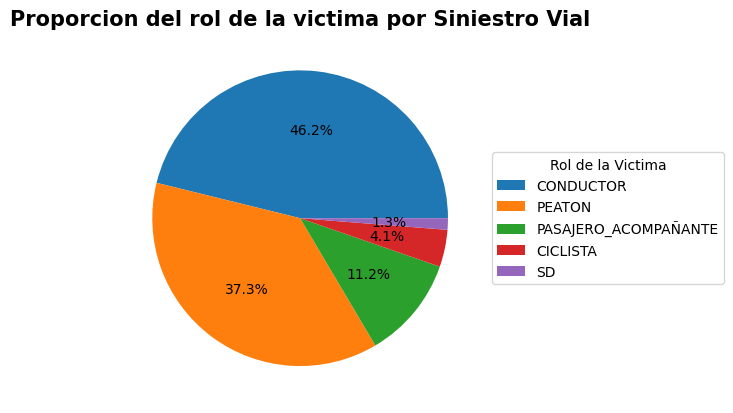

In [281]:
plt.pie(victimas['ROL'].value_counts(),autopct='%1.1f%%')
plt.title('Proporcion del rol de la victima por Siniestro Vial',fontsize=15,fontweight='bold',loc='center')
plt.legend(['CONDUCTOR','PEATON','PASAJERO_ACOMPAÑANTE','CICLISTA','SD'],title='Rol de la Victima',loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Victima

De la misma manera que en el analisis a la tabla *'HECHOS'*, se obtuvo que la mayor parte de las victimas eran *PEATONES* o *MOTOCICLISTAS*.

In [282]:
victimas['VICTIMA'].value_counts()

VICTIMA
MOTO         303
PEATON       267
AUTO          94
BICICLETA     29
CARGAS         7
SD             7
PASAJEROS      5
MOVIL          3
Name: count, dtype: int64

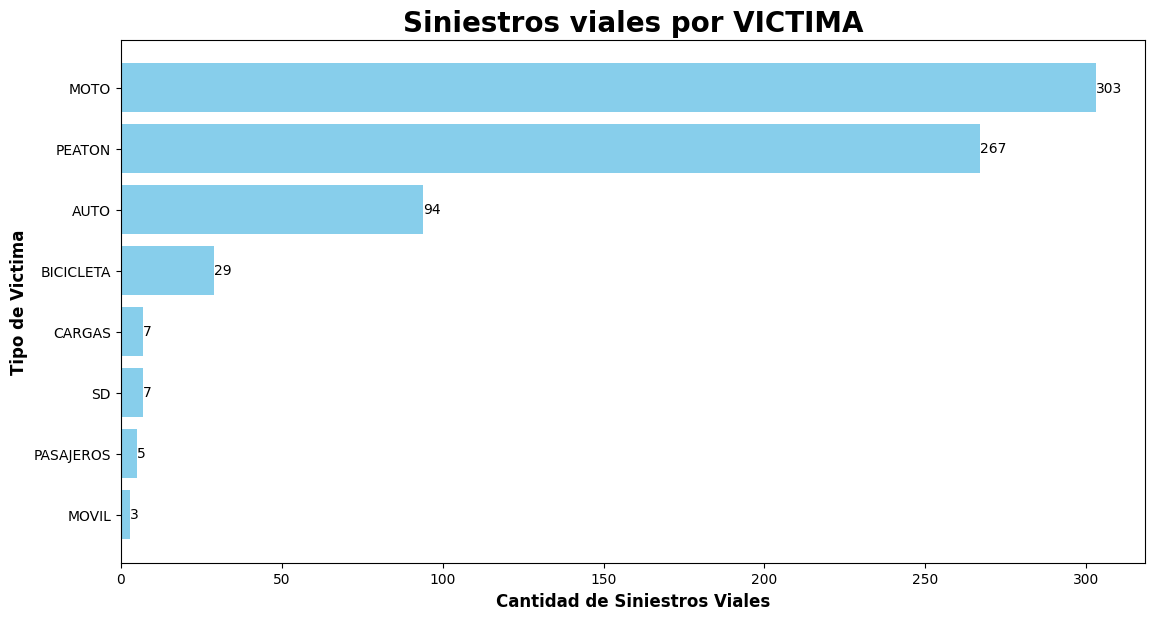

In [283]:
plt.subplots_adjust(left=0.2, right=1.8,top=1.2)
plt.barh(victimas['VICTIMA'].value_counts().index,victimas['VICTIMA'].value_counts().values,color='skyblue')
plt.gca().invert_yaxis()
plt.title('Siniestros viales por VICTIMA', fontweight = 'bold',fontsize=20)
plt.yticks(ticks=victimas['VICTIMA'].value_counts().index)
plt.ylabel('Tipo de Victima',fontweight = 'bold',fontsize=12)
plt.xlabel('Cantidad de Siniestros Viales',fontweight = 'bold',fontsize=12)

VICTIMA_counts = victimas['VICTIMA'].value_counts().sort_values(ascending=False)
for index, value in enumerate(VICTIMA_counts.values):
    plt.text(value, index, str(value), va='center')
plt.show()

### Sexo

Al analizar el sexo de la victima, se encontró que mas del 75% de ellas eran de sexo masculino y que no se tiene registro de unicamnete 4 victimas.

In [284]:
victimas['SEXO'].value_counts()

SEXO
MASCULINO    545
FEMENINO     166
SD             4
Name: count, dtype: int64

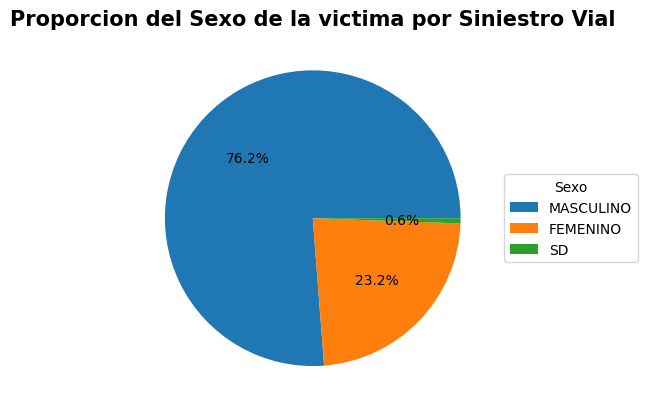

In [285]:
plt.pie(victimas['SEXO'].value_counts(),autopct='%1.1f%%')
plt.title('Proporcion del Sexo de la victima por Siniestro Vial',fontsize=15,fontweight='bold',loc='center')
plt.legend(['MASCULINO','FEMENINO','SD'],title='Sexo',loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### Edad

Se graficaron los datos de **'EDAD'** para entender como en que rango se encuentran y como se distribuyen. Se encontro que los datos se distribuyen entre 1 y 95 años y aunque la media es 41 años y la moda 30 años, los datos no se encuentran concentrados significativamente hacia un valor de manera que no se considero la existencia de outliers y esto se verifico haciendo uso de un BoxPlot

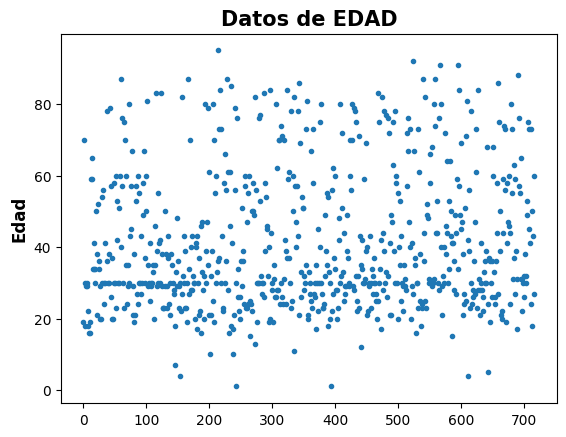

In [286]:
plt.plot(victimas['EDAD'],'o',markersize=3)
plt.title('Datos de EDAD',fontweight='bold', fontsize=15)
plt.ylabel('Edad',fontweight = 'bold',fontsize=12)
plt.show()

In [287]:
victimas['EDAD'].describe()

count    715.000000
mean      41.299301
std       19.324008
min        1.000000
25%       28.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: EDAD, dtype: float64

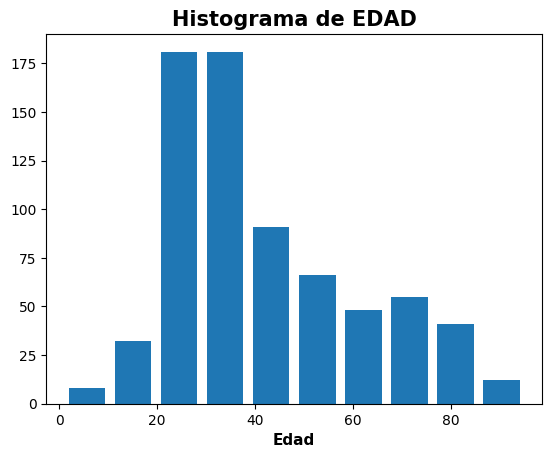

In [288]:
plt.hist(victimas['EDAD'], rwidth=0.8)
plt.title('Histograma de EDAD',fontweight='bold', fontsize=15)
plt.xlabel('Edad',fontweight = 'bold',fontsize=11)
plt.show()

In [289]:
#Calculo de bigotes
Q3 = float(victimas['EDAD'].quantile(0.75))
Q1 = float(victimas['EDAD'].quantile(0.25))
RIC = Q3 - Q1

Min_ser_bp = Q1 - 1.5*RIC
if Min_ser_bp < min(victimas['EDAD']):
    Min_ser_bp = min(victimas['EDAD'])
Max_ser_bp = Q3 + 1.5*RIC
if Max_ser_bp > max(victimas['EDAD']):
    Max_ser_bp = max(victimas['EDAD'])

Min_ser_bp, Max_ser_bp

(1, 95)

Text(0.5, 1.0, 'BoxPlot de EDAD')

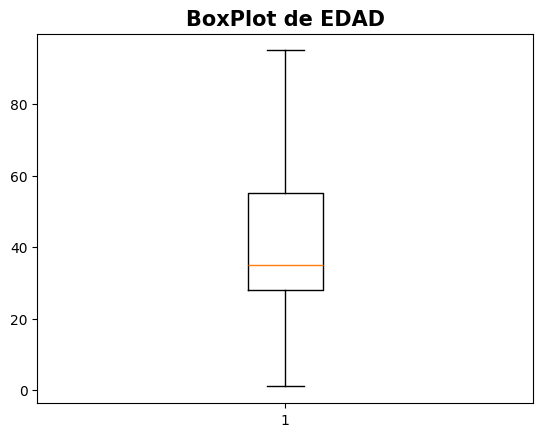

In [290]:
plt.boxplot(victimas['EDAD'])
plt.title('BoxPlot de EDAD',fontweight='bold', fontsize=15)

## Analisis de Correlacion

Se realizó el analisis de correlacion inicialmente con las variables numericas que se tenian, sin embargo para profundizar se decidió codificar las correspondientes a variables categoricas ('ROL', 'VICTIMA' y 'SEXO'). Al realizar este cambio, se encontraron muchas mas correlaciones que con el analisis inicial. Especialmente entre los tipo de victimas y los roles como entre VICTIMA_BICICLETA y ROL_CICLISTA que estan directamente relacionados ya que son la unica alternativa el uno para el otro, es decir correlacion de 1. Tambien se encontraron correlaciones inversas marcadas como es el caso de VICTIMA_PEATON y ROL_CONDUCTOR que no deberian presentarme en la realidad, y casos que son mutuamente excluyentes como lo son sexo FEMENINO y MASCULINO con correlacion de -1.

In [291]:
victimas_corr = victimas[['AÑO', 'MES', 'DIA_SEMANA','EDAD']]

In [292]:
corre = victimas_corr.corr()
corre

,AÑO,MES,DIA_SEMANA,EDAD
AÑO,1.000000,-0.038329,-0.013737,0.092922
MES,-0.038329,1.000000,-0.051527,0.026132
DIA_SEMANA,-0.013737,-0.051527,1.000000,-0.086819
EDAD,0.092922,0.026132,-0.086819,1.000000


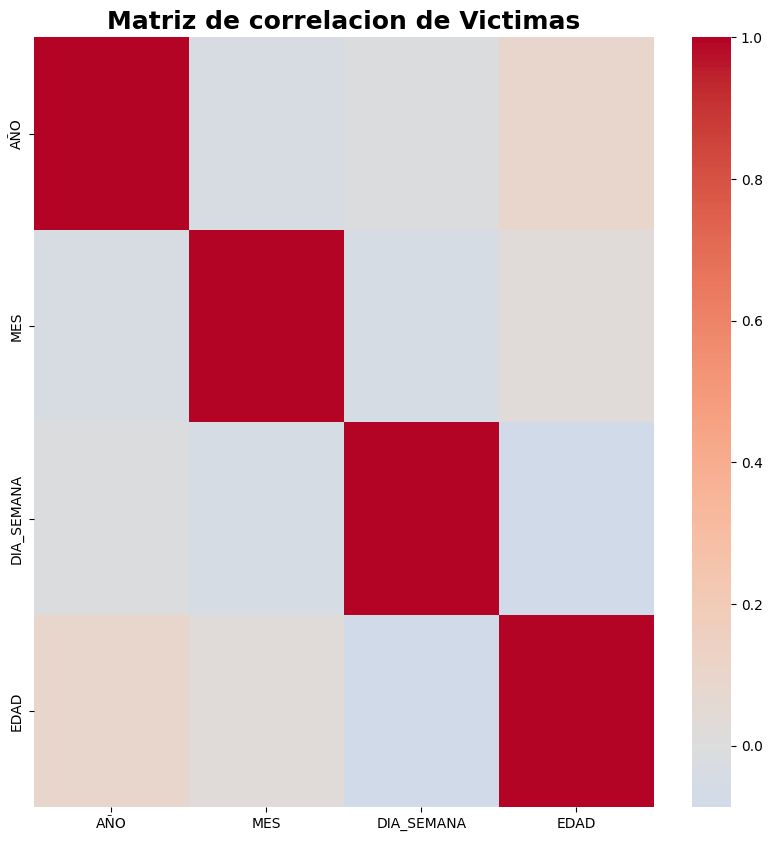

In [293]:
plt.figure(figsize=(10,10))
plt.title('Matriz de correlacion de Victimas', fontweight='bold', fontsize = 18)
sns.heatmap(corre,cmap='coolwarm',center=0)
plt.show()

In [294]:
dummies = pd.get_dummies(victimas[['ROL', 'VICTIMA', 'SEXO']])
victimas_corr = pd.concat([victimas_corr, dummies], axis=1)
victimas_corr

,AÑO,MES,DIA_SEMANA,EDAD,ROL_CICLISTA,ROL_CONDUCTOR,ROL_PASAJERO_ACOMPAÑANTE,ROL_PEATON,ROL_SD,VICTIMA_AUTO,VICTIMA_BICICLETA,VICTIMA_CARGAS,VICTIMA_MOTO,VICTIMA_MOVIL,VICTIMA_PASAJEROS,VICTIMA_PEATON,VICTIMA_SD,SEXO_FEMENINO,SEXO_MASCULINO,SEXO_SD
0,2016,1,4,19,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
1,2016,1,5,70,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,2016,1,6,30,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
3,2016,1,6,18,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,2016,1,3,29,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2021,12,6,50,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
713,2021,12,0,18,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False
714,2021,12,0,43,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False
715,2021,12,3,27,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False


In [295]:
corre_exp = victimas_corr.corr()
corre_exp

,AÑO,MES,DIA_SEMANA,EDAD,ROL_CICLISTA,ROL_CONDUCTOR,ROL_PASAJERO_ACOMPAÑANTE,ROL_PEATON,ROL_SD,VICTIMA_AUTO,VICTIMA_BICICLETA,VICTIMA_CARGAS,VICTIMA_MOTO,VICTIMA_MOVIL,VICTIMA_PASAJEROS,VICTIMA_PEATON,VICTIMA_SD,SEXO_FEMENINO,SEXO_MASCULINO,SEXO_SD
AÑO,1.000000,-0.038329,-0.013737,0.092922,0.075439,0.010856,-0.051635,0.015286,-0.102351,-0.024686,0.075439,-0.078796,0.009039,-0.032928,0.011035,0.015286,-0.095809,0.010018,0.007223,-0.097939
MES,-0.038329,1.000000,-0.051527,0.026132,0.071730,-0.044906,0.042464,-0.013749,0.013464,0.015742,0.071730,0.048544,-0.044903,-0.018518,0.035598,-0.013749,0.028654,0.054955,-0.063942,0.053874
DIA_SEMANA,-0.013737,-0.051527,1.000000,-0.086819,-0.021967,0.048097,0.081417,-0.094969,0.005641,0.147100,-0.021967,-0.000480,-0.006931,0.010355,-0.008681,-0.094969,0.041544,0.025112,-0.026462,0.008884
EDAD,0.092922,0.026132,-0.086819,1.000000,-0.020810,-0.328310,-0.145196,0.438126,0.014491,-0.027464,-0.020810,-0.003012,-0.420162,-0.016693,0.089090,0.438126,0.030825,0.230261,-0.220680,-0.043889
ROL_CICLISTA,0.075439,0.071730,-0.021967,-0.020810,1.000000,-0.190355,-0.072979,-0.158728,-0.023214,-0.079994,1.000000,-0.020444,-0.176323,-0.013346,-0.017254,-0.158728,-0.020444,0.021278,-0.018401,-0.015422
ROL_CONDUCTOR,0.010856,-0.044906,0.048097,-0.328310,-0.190355,1.000000,-0.328613,-0.714732,-0.104531,0.179462,-0.190355,-0.006576,0.687838,-0.016693,-0.077693,-0.714732,-0.092057,-0.376195,0.372091,0.005787
ROL_PASAJERO_ACOMPAÑANTE,-0.051635,0.042464,0.081417,-0.145196,-0.072979,-0.328613,1.000000,-0.274015,-0.040075,0.242675,-0.072979,0.144954,0.045772,0.114239,0.236427,-0.274015,0.009769,0.162108,-0.156112,-0.026623
ROL_PEATON,0.015286,-0.013749,-0.094969,0.438126,-0.158728,-0.714732,-0.274015,1.000000,-0.087164,-0.300355,-0.158728,-0.076762,-0.662048,-0.050111,-0.064785,1.000000,-0.076762,0.280849,-0.275189,-0.019139
ROL_SD,-0.102351,0.013464,0.005641,0.014491,-0.023214,-0.104531,-0.040075,-0.087164,1.000000,-0.043928,-0.023214,-0.011227,-0.020665,-0.007329,-0.009475,-0.087164,0.753257,-0.032372,0.004121,0.159728
VICTIMA_AUTO,-0.024686,0.015742,0.147100,-0.027464,-0.079994,0.179462,0.242675,-0.300355,-0.043928,1.000000,-0.079994,-0.038686,-0.333650,-0.025254,-0.032649,-0.300355,-0.038686,-0.066893,0.071456,-0.029182


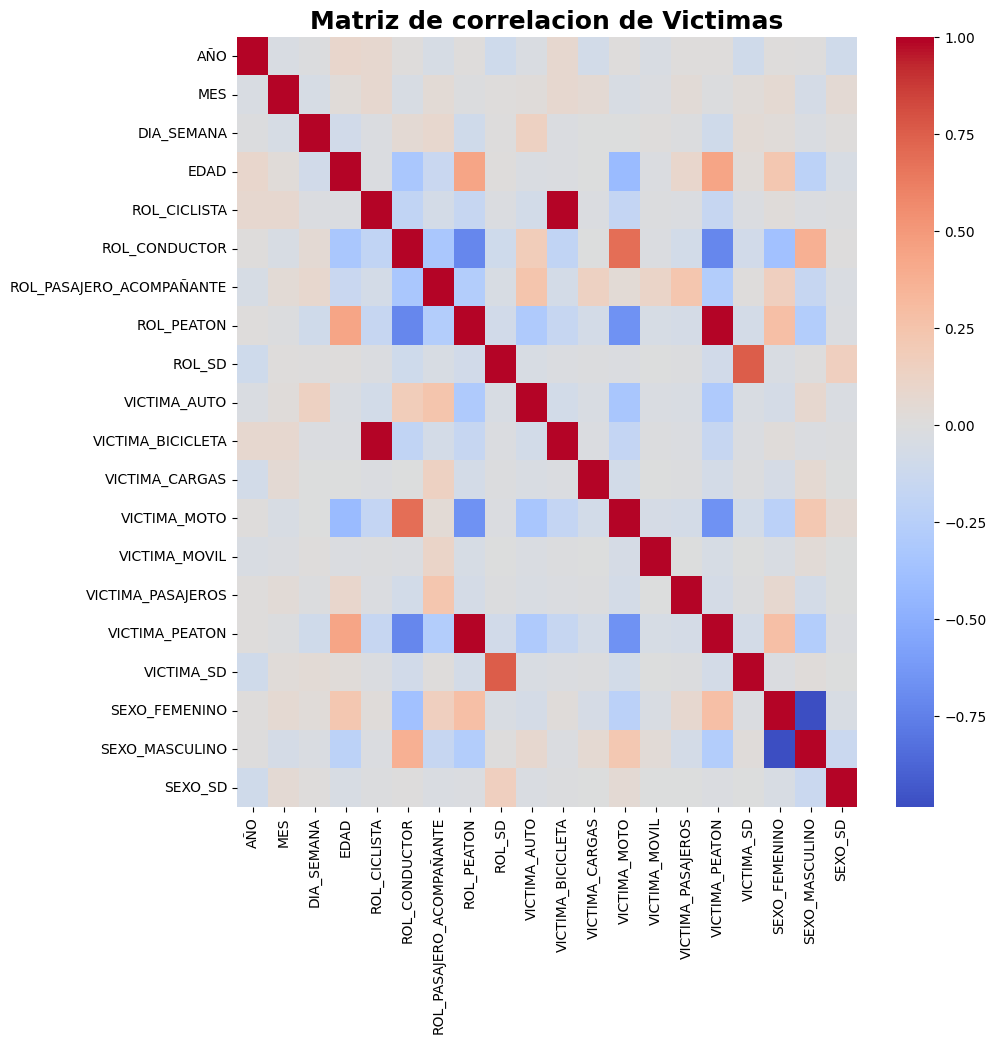

In [296]:
plt.figure(figsize=(10,10))
plt.title('Matriz de correlacion de Victimas', fontweight='bold', fontsize = 18)
sns.heatmap(corre_exp,cmap='coolwarm',center=0)
plt.show()

## Exportar archivos

In [297]:
victimas_vis

,ID,AÑO,MES_NOM,MES,DIA_SEMANA_NOM,DIA_SEMANA,ROL,VICTIMA,SEXO,EDAD
0,2016-0001,2016,ENERO,1,VIERNES,4,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,2016,ENERO,1,SÁBADO,5,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,2016,ENERO,1,DOMINGO,6,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,2016,ENERO,1,DOMINGO,6,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,2016,ENERO,1,JUEVES,3,CONDUCTOR,MOTO,MASCULINO,29
...,...,...,...,...,...,...,...,...,...,...
712,2021-0092,2021,DICIEMBRE,12,DOMINGO,6,PEATON,PEATON,FEMENINO,50
713,2021-0093,2021,DICIEMBRE,12,LUNES,0,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,18
714,2021-0094,2021,DICIEMBRE,12,LUNES,0,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,43
715,2021-0095,2021,DICIEMBRE,12,JUEVES,3,CONDUCTOR,MOTO,MASCULINO,27


In [298]:
victimas.head(10)

,ID,AÑO,MES,DIA_SEMANA,ROL,VICTIMA,SEXO,EDAD
0,2016-0001,2016,1,4,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,2016,1,5,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,2016,1,6,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,2016,1,6,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,2016,1,3,CONDUCTOR,MOTO,MASCULINO,29
5,2016-0008,2016,1,6,CONDUCTOR,MOTO,MASCULINO,30
6,2016-0009,2016,1,6,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,29
7,2016-0010,2016,1,4,CONDUCTOR,MOTO,MASCULINO,18
8,2016-0012,2016,2,0,CONDUCTOR,MOTO,MASCULINO,22
9,2016-0013,2016,2,2,PEATON,PEATON,MASCULINO,16


In [299]:
victimas_vis.to_csv('Archivos Finales/victimas.csv', index=False)